Calculate the GOES-XRS temperature and emission measure (EM)

In [1]:
import matplotlib.pyplot as plt
from sunpy import timeseries as ts
from sunkit_instruments import goes_xrs

In [2]:
import os
import glob
seed_val = 7
import os
os.environ['PYTHONHASHSEED'] = str(seed_val)
import random
random.seed(seed_val)
import numpy as np
np.random.seed(seed_val)
from scipy.optimize import fsolve as fsolver
import pandas as pd
import sunpy
from astropy import units as u
from sunpy.net import Fido, attrs as a
import requests
from bs4 import BeautifulSoup
from spacepy import pycdf
from scipy.ndimage import gaussian_filter
from astropy.visualization import ImageNormalize, PercentileInterval
from sunpy import timeseries as ts
import matplotlib.dates as mdates
from PIL import Image
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib import colors
import matplotlib.colors as mcolors

data_dir = '/home/mnedal/data'

In [3]:
import sunpy
print(sunpy.config.get('downloads', 'sample_dir'))

/net/maedoc.ap.dias.ie/maedoc/home_cr/mnedal/.local/share/sunpy


In [13]:
def fetch_xrs(data_dir=None, dt=None, year=None, month=None, day=None):
    """
    Download GOES/XRS data.
        dt: Datetime/Timestamp object.
        Inputs: year, month, day.
    """
    try:
        os.makedirs(f'{data_dir}/XRS/', exist_ok=True)
    except:
        pass
    
    if year == 2019:
        # Check if the file doesn't exist
        file_path = f'{data_dir}/XRS/sci_xrsf-l2-flx1s_g17_d{year}{month}{day}_v2-2-0.nc'

        if not os.path.exists(file_path):
            # get the data file
            URL = f'https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes17/l2/data/xrsf-l2-flx1s_science/{year}/{month}/sci_xrsf-l2-flx1s_g17_d{year}{month}{day}_v2-2-0.nc'
            response = requests.get(URL)
            open(os.path.join(f'{data_dir}/XRS', f'sci_xrsf-l2-flx1s_g17_d{year}{month}{day}_v2-2-0.nc'), 'wb').write(response.content)

        goes = ts.TimeSeries(file_path)
    else:
        file_path = f'{data_dir}/XRS/sci_xrsf-l2-avg1m_g16_d{year}{month}{day}_v2-2-0.nc'
        
        if not os.path.exists(file_path):
            goes_result = Fido.search(a.Time(f'{dt.date()}', f'{dt.date()}'), a.Instrument('XRS'), a.Resolution('1S'), a.goes.SatelliteNumber(17))
            goes_file = Fido.fetch(goes_result, path=f'{data_dir}/XRS/')
            goes = ts.TimeSeries(goes_file)
        else:
            goes = ts.TimeSeries(file_path)
    return goes

In [100]:
# tr = a.Time('2024-05-14 04:00', '2024-05-14 12:00')
tr = a.Time('2024-05-14', '2024-05-14')
results = Fido.search(tr, a.Instrument.xrs & a.goes.SatelliteNumber(16) & a.Resolution("avg1m") | a.hek.FL & (a.hek.FRM.Name == 'SWPC'))

In [107]:
try:
    os.makedirs(f'{data_dir}/XRS/', exist_ok=True)
except:
    pass

# # Check if the file doesn't exist
# file_path = f'{data_dir}/XRS/sci_xrsf-l2-flx1s_g17_d{year}{month}{day}_v2-2-0.nc'

# if not os.path.exists(file_path):
#     # get the data file
#     URL = f'https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes17/l2/data/xrsf-l2-flx1s_science/{year}/{month}/sci_xrsf-l2-flx1s_g17_d{year}{month}{day}_v2-2-0.nc'
#     response = requests.get(URL)
#     open(os.path.join(f'{data_dir}/XRS', f'sci_xrsf-l2-flx1s_g17_d{year}{month}{day}_v2-2-0.nc'), 'wb').write(response.content)

# goes = ts.TimeSeries(file_path)

# file_path = f'{data_dir}/XRS/sci_xrsf-l2-avg1m_g16_d{year}{month}{day}_v2-2-0.nc'

date = '2024-05-14'
year, month, day = date.split('-')

goes_result = Fido.search(a.Time(date, date), a.Instrument('XRS'), a.goes.SatelliteNumber(16))
goes_file = Fido.fetch(goes_result, path=f'{data_dir}/XRS/')
goes = ts.TimeSeries(goes_file)

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

In [108]:
# date = '2024-05-14'
# year, month, day = date.split('-')

# goes = fetch_xrs(data_dir=data_dir, dt=pd.Timestamp(date), year=year, month=month, day=day)

In [109]:
df_goes = goes[0].to_dataframe()
df_goes.head()

,xrsa,xrsb,xrsa_quality,xrsb_quality,xrsa_primary_chan,xrsb_primary_chan
2024-05-13 23:59:59.930738,1.088746e-07,0.000004,0,0,1,1
2024-05-14 00:00:00.930744,1.228981e-07,0.000004,0,0,1,1
2024-05-14 00:00:01.930745,1.196619e-07,0.000004,0,2,1,1
2024-05-14 00:00:02.930749,1.163945e-07,0.000004,0,0,1,1
2024-05-14 00:00:03.930754,1.239768e-07,0.000004,0,0,1,1


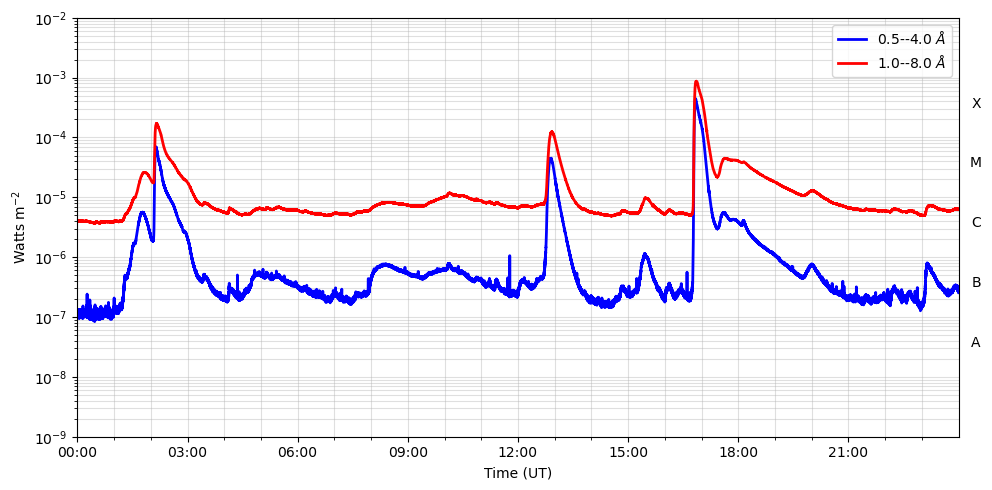

In [110]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)
goes[0].plot(axes=ax)
ax.set_xlabel('Time (UT)')
ax.grid(alpha=0.4, which='both')
ax.legend(loc='upper right')
ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.set_xlim(left=df_goes.index[0], right=df_goes.index[-1])
fig.tight_layout()
# fig.savefig('/HDD/mnedal/plots/goes_xrs.pdf', format='pdf', bbox_inches='tight')
# fig.savefig('/HDD/mnedal/plots/goes_xrs.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

In [128]:
start_time = '2024-05-14T17:00:15'
# start_time = '2024-05-14T16:30:00'
end_time   = '2024-05-14T19:00:01'

goes_flare = goes[0].truncate(start_time, end_time)
goes_temp_em = goes_xrs.calculate_temperature_em(goes_flare)

In [129]:
df_flare = goes_flare.to_dataframe()
df_flare.head()

,xrsa,xrsb,xrsa_quality,xrsb_quality,xrsa_primary_chan,xrsb_primary_chan
2024-05-14 17:00:15.101480,0.000152,0.000455,0,0,2,2
2024-05-14 17:00:16.101481,0.000152,0.000453,0,0,2,2
2024-05-14 17:00:17.101486,0.000152,0.000453,0,0,2,2
2024-05-14 17:00:18.101491,0.000151,0.000452,0,0,2,2
2024-05-14 17:00:19.101491,0.000151,0.000451,0,0,2,2


In [130]:
df_goes_temp_em = goes_temp_em.to_dataframe()
df_goes_temp_em.head()

,temperature,emission_measure
2024-05-14 17:00:15.101480,17.632040,1.481101e+50
2024-05-14 17:00:16.101481,17.644968,1.475975e+50
2024-05-14 17:00:17.101486,17.641747,1.476877e+50
2024-05-14 17:00:18.101491,17.635531,1.473675e+50
2024-05-14 17:00:19.101491,17.648655,1.470298e+50


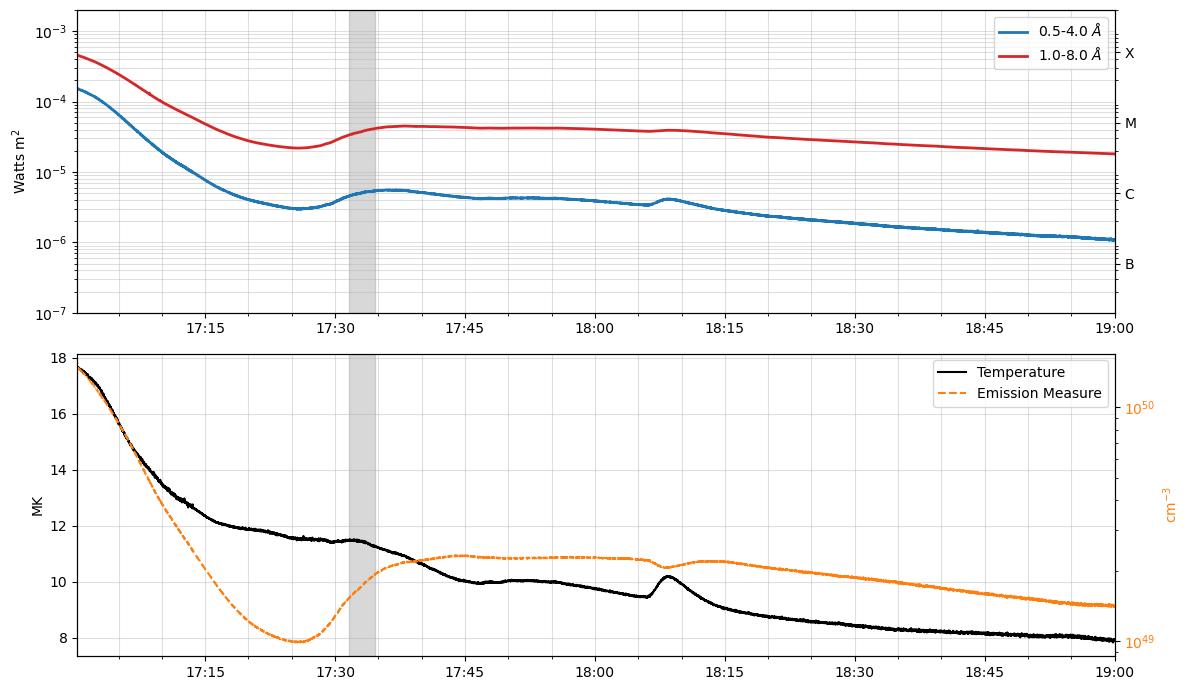

In [131]:
time1 = pd.Timestamp('2024-05-14T17:31:35')
time2 = pd.Timestamp('2024-05-14T17:34:35')

fig = plt.figure(figsize=[12,7])

ax = fig.add_subplot(211)
# goes_flare.plot(axes=ax)
ax.plot(df_flare['xrsa'], color='tab:blue', lw=2, label=r'0.5-4.0 $\AA$')
ax.plot(df_flare['xrsb'], color='tab:red', lw=2, label=r'1.0-8.0 $\AA$')
ax.set_yscale('log')
ax.grid(alpha=0.4, which='both')
ax.legend(loc='upper right')
ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.set_xlim(left=df_flare.index[0], right=df_flare.index[-1])
ax.set_ylim(bottom=1e-7, top=2e-3)
# Set custom ticks at flux levels corresponding to C, M, and X classes
flare_levels = [0.5e-6, 0.5e-5, 0.5e-4, 0.5e-3]  # Flux values for C, M, and X classes
flare_labels = ['B', 'C', 'M', 'X']     # Labels for the desired classes
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())  # Align the right y-axis with the left y-axis
ax2.set_yscale('log')        # Ensure both y-axes have the same scale
# Set custom ticks and labels for flare classes on the right y-axis
ax2.set_yticks(flare_levels)
ax2.set_yticklabels(flare_labels, color='black')
ax.set_ylabel(r'Watts m$^2$')
ax.axvspan(time1, time2, color='gray', alpha=0.3)

ax = fig.add_subplot(212)
line1, = ax.plot(df_goes_temp_em['temperature'], 'k-', label='Temperature')
ax.set_ylabel('MK')
ax.grid(alpha=0.4, which='both')
ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.set_xlim(left=df_goes_temp_em.index[0], right=df_goes_temp_em.index[-1])
# Make the right y-axis and plot the second curve
ax2 = ax.twinx()
line2, = ax2.plot(df_goes_temp_em['emission_measure'], color='tab:orange', ls='--', label=r'Emission Measure')
ax2.set_ylabel(r'cm$^{-3}$', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_yscale('log')
# ax.set_xlabel('Time (UT)')
# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper right')
ax.axvspan(time1, time2, color='gray', alpha=0.3)

fig.tight_layout()
fig.savefig(f'{data_dir}/goes_xr_EM.pdf', format='pdf', bbox_inches='tight')
fig.savefig(f'{data_dir}/png/goes_xr_EM.png', dpi=300, format='png', bbox_inches='tight')
plt.show()